In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install soynlp
!pip install konlpy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 416 kB 4.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 36.4 MB/s 
     |████████████████████████████████| 453 kB 36.8 MB/s 


In [ ]:
#!pip install gensim
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
import pandas as pd
from pandas import DataFrame  as df
import numpy as np
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt
import re 
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
from wordcloud import WordCloud
from datetime import datetime
from soynlp.tokenizer import LTokenizer
from soynlp.noun import LRNounExtractor_v2
from collections import Counter
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from konlpy.tag import Okt
import tqdm
import pandas as pd

In [ ]:
URL =""
df = pd.read_csv("../content/drive/MyDrive/Colab Notebooks/텍스트마이닝 수업/data/TextMiningCoupangData_0610.csv")

In [ ]:
df2 = df[['제조회사','별점','상품평']].drop_duplicates()
df2.reset_index(drop=True, inplace =True)

In [ ]:
df2 = df2[(df2['제조회사'] == '삼성전자') | (df2['제조회사'] == 'Apple') ]

In [ ]:
df2['제조회사'].unique()

array(['Apple', '삼성전자'], dtype=object)

In [ ]:
df2

,제조회사,별점,상품평
0,Apple,5,드뎌 왔네요 아이폰 se 2 언론에서 소위 스마트폰 생태계 교란종이라 하던데 AP...
1,Apple,5,구매에 도움이 되고자 솔직히 썼어요 구매 4 30 배송 5 7 도착 사전예약 ...
2,Apple,5,고등학생 아이가 쓸 핸드폰으로 구매했습니다 기존에 쓰던 폰도 아이폰 S...
3,Apple,5,드뎌 왔네
4,Apple,5,구매에 도움이 되고자 솔직히 썼어요 구매 4 30 배송 5 7 도착 사전예약 ...
...,...,...,...
10010,삼성전자,1,핸펀에 렉이 자꾸 걸려요 자동이로 화면 꺼질 때 까지 기다려야되요 핸펀 후졌어요
10011,삼성전자,1,절대 이거 사지마세요 산지 두달만에 갑자기 지혼자 뜨거워지도니 꺼지고 터치 안먹는데...
10012,삼성전자,1,충전기 정품아닙니다 한번 썻는데 고장이네요 다이소에서 사도 이것보단 나을듯
10013,삼성전자,1,별점도 아까움


# 1. 전체 토픽 모델링

In [ ]:
def preprocess(data,stopwords):
  data_word=[]
  for i in tqdm.tqdm(range(len(list(data['상품평'])))):
    try:
      okt = Okt()
      tem = okt.nouns(data['상품평'][i])
      tem = [t for t in tem if t not in stopwords]
      data_word.append(tem)
    except:
      print("skip")
      #data_word.append([''])

  high_score_reviews = data_word
  high_score_reviews = [[y for y in x if not len(y)==1]
                      for x in high_score_reviews]
  dictionary = corpora.Dictionary(high_score_reviews)
  corpus = [dictionary.doc2bow(text) for text in high_score_reviews]

  return data_word,corpus,dictionary,high_score_reviews

In [ ]:
stopwords = ["구매","아주","아이폰","삼성",'갤럭시','정말','중고','제품','상품','박스','할인','핸드폰','휴대폰','진짜','사람','정도','그냥','사용','역시','듭니','조금','애플','노트','플립','미니','프로','생각','없음','배송','쿠팡','로켓','플립',
             '폴드','프맥','프로맥스','바로','완전','울트라','골드','시에라','블루','블랙','화이트','실버','맥스','라벤더','레드','매우','없음 ',' 없음',' 없음 ','핑크','흰색','부모님','아빠','어머니','자녀','엄마','도착','새벽','포장','금제','남편','다시',
             '최고','고민','사은','이번','자급','핸펀','별로','산다','사지','누가','사드','별로','의미','택배','흔적','처음','관련','자꾸','에두','아버지','전자제품','오후','혼자','닌지','시리즈','개봉','드릴','개통','작년','사도','점도','채도','오늘',
             '장사','기기','구리','후기','구입']

data_word,corpus,dictionary,high_score_reviews = preprocess(df2,stopwords)

 14%|█▎        | 1360/10015 [00:14<00:25, 344.76it/s]

skip


100%|██████████| 10015/10015 [02:03<00:00, 81.14it/s]


In [ ]:
perplexity_values=[]
coherence_values=[]
for i in range(2,30):
  ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
  coherence_model_lda=CoherenceModel(model=ldamodel, texts=high_score_reviews, dictionary=dictionary,topn=10)
  coherence_lda=coherence_model_lda.get_coherence()
  coherence_values.append(coherence_lda)
  perplexity_values.append(ldamodel.log_perplexity(corpus))

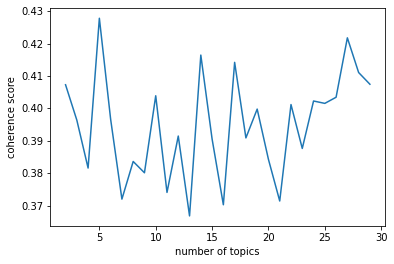

In [ ]:
x=range(2,30)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

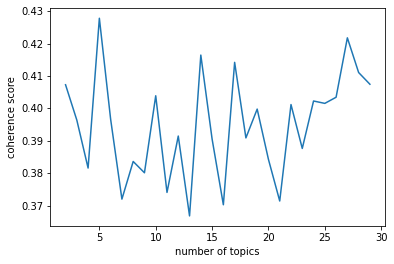

In [ ]:
x=range(2,30)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

In [ ]:
coherence_values[0]

0.40729968501081215

In [ ]:
np.mean(coherence_values,axis = 0)

array([0.45280418, 0.47448848, 0.47548274, 0.49774947, 0.49462931,
       0.49384672, 0.50305481, 0.50389385, 0.49305675, 0.50255997,
       0.4881101 , 0.49598417, 0.48802796])

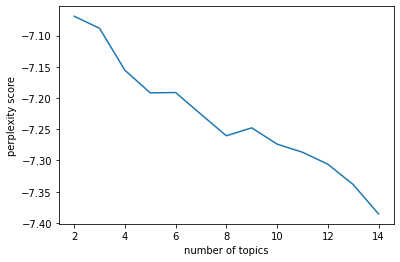

In [ ]:
x=range(2,15)
plt.plot(x, perplexity_values[0])
plt.xlabel("number of topics")
plt.ylabel("perplexity score")
plt.show()

In [ ]:
# 선택
ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=14, id2word=dictionary)
coherence_model_lda=CoherenceModel(model=ldamodel, texts=high_score_reviews, dictionary=dictionary,topn=5)
coherence_lda=coherence_model_lda.get_coherence()
#coherence_values.append(coherence_lda)
ldamodel.print_topics(num_words=20)


[(0,
  '0.020*"요금" + 0.014*"버즈" + 0.014*"색상" + 0.013*"신청" + 0.011*"약정" + 0.011*"혜택" + 0.011*"가격" + 0.010*"카드" + 0.010*"제로" + 0.009*"선택" + 0.009*"기본" + 0.009*"데이터" + 0.009*"조건" + 0.008*"지원" + 0.008*"추천" + 0.008*"변경" + 0.008*"서비스" + 0.008*"이자" + 0.007*"추가" + 0.007*"사전예약"'),
 (1,
  '0.055*"신뢰" + 0.052*"양심" + 0.021*"보급" + 0.017*"케이스" + 0.013*"가격" + 0.013*"고장" + 0.011*"화면" + 0.009*"색상" + 0.009*"플라스틱" + 0.009*"필름" + 0.009*"기분" + 0.009*"터치" + 0.009*"무게" + 0.008*"유심" + 0.008*"보호" + 0.008*"게속" + 0.008*"샤워" + 0.007*"추천" + 0.007*"제일" + 0.007*"선물"'),
 (2,
  '0.048*"연결" + 0.041*"다음" + 0.037*"종일" + 0.036*"영상통화" + 0.030*"대리점" + 0.028*"이어폰" + 0.028*"품질" + 0.016*"사진" + 0.013*"한번" + 0.012*"통신사" + 0.010*"어플" + 0.010*"설명" + 0.009*"카드" + 0.009*"충전" + 0.008*"크림" + 0.008*"엣지" + 0.008*"가격" + 0.008*"기능" + 0.007*"유심" + 0.007*"계속"'),
 (3,
  '0.055*"가입" + 0.054*"불량" + 0.037*"상태" + 0.030*"상자" + 0.028*"완충제" + 0.027*"습기" + 0.027*"미사" + 0.027*"우롱" + 0.027*"거폰" + 0.025*"주문" + 0.019*"고장" + 0.018*"소비자" + 0.017*"케어" + 0.

In [ ]:
ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary)
coherence_model_lda=CoherenceModel(model=ldamodel, texts=high_score_reviews, dictionary=dictionary,topn=9)
coherence_lda=coherence_model_lda.get_coherence()
coherence_values.append(coherence_lda)

In [ ]:
def format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data_word):

  # Init output
  sent_topics_df = pd.DataFrame()

  # Get main topic in each document
  for i, row in enumerate(ldamodel[corpus]):
      row = sorted(row, key=lambda x: (x[1]), reverse=True)
      # Get the Dominant topic, Perc Contribution and Keywords for each document
      for j, (topic_num, prop_topic) in enumerate(row):
          if j == 0:  # => dominant topic
              wp = ldamodel.show_topic(topic_num)
              topic_keywords = ", ".join([word for word, prop in wp])
              sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
          else:
              break
  sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

  # Add original text to the end of the output
  contents = pd.Series(texts)
  sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
  return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data_word)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.9596,"구매, 가격, 가성, 성능, 디자인, 만족, 아이폰, 제품, 사용, 갤럭시","[서울, 기지역, 구매, 만, 하루, 총알, 배송, 만족, 제품, 개봉, 하자, 부..."
1,1,3.0,0.7906,"구매, 가격, 가성, 성능, 디자인, 만족, 아이폰, 제품, 사용, 갤럭시","[하루, 도착, 배송, 굿, 기존, 핸펀, 메이, 보드, 고장, 수리, 구입, 기존..."
2,2,3.0,0.8281,"구매, 가격, 가성, 성능, 디자인, 만족, 아이폰, 제품, 사용, 갤럭시","[아들, 휴대폰, 액정, 검색, 종이, 블루, 색, 주문, 색도, 제일, 삼성, 페..."
3,3,6.0,0.9671,"카메라, 사용, 갤럭시, 기능, 발열, 아이폰, 배터리, 성능, 사진, 정말","[이, 가격, 걸, 논, 일단, 인물사진, 삼성, 페이도, 오, 처음, 뭔가, 살짝..."
4,4,0.0,0.7105,"아이폰, 배터리, 사용, 아주, 생각, 역시, 구매, 최고, 애플, 화면","[서브, 폰, 걸, 구매, 스펙, 그닥, 중요, 치가, 디자인, 보고, 구매, 제,..."
5,5,0.0,0.6560,"아이폰, 배터리, 사용, 아주, 생각, 역시, 구매, 최고, 애플, 화면","[아이폰, 세컨폰, 회사, 전화, 문자, 카톡, 유튜브, 용도, 구입, 거, 이, ..."
6,6,1.0,0.5317,"배송, 제품, 상품, 포장, 구매, 박스, 쿠팡, 사용, 상태, 도착","[배송, 가격, 보호, 필름, 기본, 투명, 젤리, 케이스, 핸드폰, 주네, 충전기..."
7,7,5.0,0.6096,"사진, 생각, 화면, 색상, 구매, 그냥, 고민, 정도, 배송, 카메라","[실제, 색상, 아크릴, 톡, 페인트, 거마, 채도, 하늘색, 임, 서브, 폰, 려..."
8,8,8.0,0.9682,"사용, 할인, 구매, 구입, 쿠팡, 자급, 아이폰, 카드, 가격, 핸드폰","[가격, 품질, 그, 비례, 함, 가성, 비, 인정, 추후, 발생, 비용, 포함, ..."
9,9,6.0,0.6960,"카메라, 사용, 갤럭시, 기능, 발열, 아이폰, 배터리, 성능, 사진, 정말","[가격, 폰, 좋숩니, 삼페, 아몰레드, 크게, 신경, 오히려, 번인, 걱정, 다만..."


In [ ]:
df_dominant_topic.to_csv("topic_modeling_result.csv",index=False)

# 2. 상품별 토픽 모델링 진행


In [ ]:
df_samsung = df2[df2['제조회사']== '삼성전자']
df_apple = df2[df2['제조회사']== 'Apple']

In [ ]:
df_samsung.reset_index(inplace =True)

In [ ]:
df_samsung

,index,제조회사,별점,상품평
0,5228,삼성전자,5,서울 경기지역이 아닌데도 구매하고 만 하루만에 총알배송에 만족 제품도 개봉이나 하자...
1,5229,삼성전자,5,주문하루만에 도착 빠른 배송 굿 기존에 쓰던 핸펀 메이보드고장이라고 수리하느니...
2,5230,삼성전자,5,아들 오래된 휴대폰 액정이 깨져서 급하게 검색했더니 a23기종이 보이네요 블루색...
3,5231,삼성전자,5,이 가격에 다른걸 논하는건 웃긴것 같아요 일단 의외로 인물사진 되서 놀라웠고 삼성...
4,5232,삼성전자,5,서브폰이 급히 필요해서 이걸로 구매했어요 스펙은 그닥 중요치가 않아서 디자인만 보고...
...,...,...,...,...
4782,10010,삼성전자,1,핸펀에 렉이 자꾸 걸려요 자동이로 화면 꺼질 때 까지 기다려야되요 핸펀 후졌어요
4783,10011,삼성전자,1,절대 이거 사지마세요 산지 두달만에 갑자기 지혼자 뜨거워지도니 꺼지고 터치 안먹는데...
4784,10012,삼성전자,1,충전기 정품아닙니다 한번 썻는데 고장이네요 다이소에서 사도 이것보단 나을듯
4785,10013,삼성전자,1,별점도 아까움


In [ ]:
stopwords = ["구매","아주","아이폰","삼성",'갤럭시','정말','중고','제품','상품','박스','할인','핸드폰','휴대폰','진짜','사람','정도','그냥','사용','역시','듭니','조금','애플','노트','플립','미니','프로','생각','없음','배송','쿠팡','로켓','플립',
             '폴드','프맥','프로맥스','바로','완전','울트라','골드','시에라','블루','블랙','화이트','실버','맥스','라벤더','레드','매우','없음 ',' 없음',' 없음 ','핑크','흰색','부모님','아빠','어머니','자녀','엄마','도착','새벽','포장','금제','남편','다시',
             '최고','고민','사은','이번','자급','핸펀','별로','산다','사지','누가','사드','별로','의미','택배','흔적','처음','관련','자꾸','에두','아버지','전자제품','오후','혼자','닌지','시리즈','개봉','드릴','개통','작년','사도','점도','채도','오늘',
             '장사','기기','구리','후기','구입']
data_word,corpus,dictionary,high_score_reviews = preprocess(df_samsung,stopwords)

100%|██████████| 4787/4787 [00:54<00:00, 88.46it/s]


In [ ]:
perplexity_values=[]
coherence_values=[]
for i in range(2,30):
  ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
  coherence_model_lda=CoherenceModel(model=ldamodel, texts=high_score_reviews, dictionary=dictionary,topn=10)
  coherence_lda=coherence_model_lda.get_coherence()
  coherence_values.append(coherence_lda)
  perplexity_values.append(ldamodel.log_perplexity(corpus))

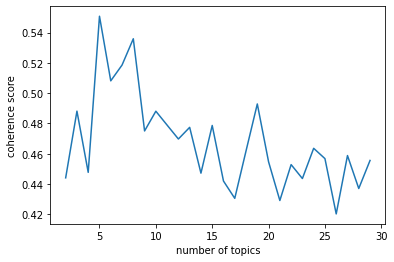

In [ ]:
x=range(2,30)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

In [ ]:
ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary)
coherence_model_lda=CoherenceModel(model=ldamodel, texts=high_score_reviews, dictionary=dictionary,topn=5)
coherence_lda=coherence_model_lda.get_coherence()
coherence_values.append(coherence_lda)
ldamodel.print_topics(num_words=9)

[(0,
  '0.014*"기능" + 0.011*"카메라" + 0.010*"디자인" + 0.008*"화면" + 0.008*"신청" + 0.008*"성능" + 0.007*"배터리" + 0.007*"가격" + 0.007*"부분"'),
 (1,
  '0.012*"가격" + 0.011*"주문" + 0.010*"불량" + 0.009*"유심" + 0.008*"고객" + 0.008*"성능" + 0.007*"센터" + 0.007*"케이스" + 0.007*"통화"'),
 (2,
  '0.014*"문제" + 0.010*"센터" + 0.010*"선물" + 0.009*"가격" + 0.009*"확인" + 0.008*"상담" + 0.008*"유심" + 0.008*"교환" + 0.008*"시간"'),
 (3,
  '0.015*"화면" + 0.014*"카메라" + 0.014*"케이스" + 0.011*"사진" + 0.010*"느낌" + 0.009*"사전예약" + 0.008*"필름" + 0.007*"배터리" + 0.007*"충전"'),
 (4,
  '0.020*"배터리" + 0.018*"발열" + 0.017*"연락" + 0.015*"가격" + 0.010*"카메라" + 0.008*"환불" + 0.008*"디자인" + 0.008*"성능" + 0.008*"주문"')]

# 3. 별점 별 토픽 모델링 결과

In [ ]:
df_good = df2[df2['별점']== 5]
df_soso = df2[(df2['별점']== 3) | (df2['별점'] == 4)]
df_bad = df2[(df2['별점']== 1) | (df2['별점']== 2)]



In [ ]:
df_good.reset_index(inplace =True)
df_soso.reset_index(inplace =True)
df_bad.reset_index(inplace =True)

In [ ]:
df_soso

,index,제조회사,별점,상품평
0,4518,Apple,4,배송빠르고 좋네요 충전기랑 이어폰도 주시고 서비스 너무좋아요 그런데 실버 주문했는...
1,4519,Apple,4,구입 모델 아이폰 SE2 프로덕트 레드 256GB 구입가격 588 0...
2,4520,Apple,4,아이폰xs 잘쓰다가 고장나서 리퍼받아야하는데 비용이80만원 그래서 그냥 ...
3,4521,Apple,4,아이폰xs 잘쓰다가 고장나서 리퍼받아야하는데 비용이80만원 그래서 그냥 ...
4,4522,Apple,4,크기 때문에 se니까 작겠지 생각하고 샀는데 제 생각보다는 크네요 하지만 크기 빼고...
...,...,...,...,...
1265,9677,삼성전자,3,본체와 구성품에는 하자가 없었지만 상자가 주욱 찢어져서 와서 마음이 아팠습니다
1266,9678,삼성전자,3,배송빠르고 젛아요 부모님 폰 교체할려고주문이요
1267,9679,삼성전자,3,제품은 좋습니다 자급제에 개통이력 없는 건 확인했는데 뜯기 전부터 포장상태가 좋...
1268,9680,삼성전자,3,빠른 배송 아주 좋아요


In [ ]:
stopwords = ["구매","아주","아이폰","삼성",'갤럭시','정말','중고','제품','상품','박스','할인','핸드폰','휴대폰','진짜','사람','정도','그냥','사용','역시','듭니','조금','애플','노트','플립','미니','프로','생각','없음','배송','쿠팡','로켓','플립',
             '폴드','프맥','프로맥스','바로','완전','울트라','골드','시에라','블루','블랙','화이트','실버','맥스','라벤더','레드','매우','없음 ',' 없음',' 없음 ','핑크','흰색','부모님','아빠','어머니','자녀','엄마','도착','새벽','포장','금제','남편','다시',
             '최고','고민','사은','이번','자급','핸펀','별로','산다','사지','누가','사드','별로','의미','택배','흔적','처음','관련','자꾸','에두','아버지','전자제품','오후','혼자','닌지','시리즈','개봉','드릴','개통','작년','사도','점도','채도','오늘',
             '장사','기기','구리','후기','구입']
data_word,corpus,dictionary,high_score_reviews = preprocess(df_bad,stopwords)

100%|██████████| 460/460 [00:11<00:00, 40.50it/s]


In [ ]:
perplexity_values=[]
coherence_values=[]
for i in range(2,30):
  ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=i, id2word=dictionary)
  coherence_model_lda=CoherenceModel(model=ldamodel, texts=high_score_reviews, dictionary=dictionary,topn=10)
  coherence_lda=coherence_model_lda.get_coherence()
  coherence_values.append(coherence_lda)
  perplexity_values.append(ldamodel.log_perplexity(corpus))

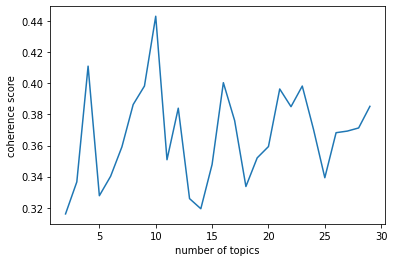

In [ ]:
x=range(2,30)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

In [ ]:
ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary)
coherence_model_lda=CoherenceModel(model=ldamodel, texts=high_score_reviews, dictionary=dictionary,topn=5)
coherence_lda=coherence_model_lda.get_coherence()
coherence_values.append(coherence_lda)
ldamodel.print_topics(num_words=9)

[(0,
  '0.012*"연락" + 0.011*"배터리" + 0.011*"환불" + 0.009*"교환" + 0.008*"센터" + 0.008*"전화" + 0.007*"처리" + 0.007*"비닐" + 0.006*"이자"'),
 (1,
  '0.023*"교환" + 0.013*"센터" + 0.011*"연락" + 0.010*"주문" + 0.008*"확인" + 0.007*"상태" + 0.007*"반품" + 0.007*"서비스" + 0.006*"액정"'),
 (2,
  '0.016*"연락" + 0.014*"교환" + 0.011*"반품" + 0.011*"센터" + 0.011*"확인" + 0.009*"고객" + 0.009*"불량" + 0.009*"카메라" + 0.007*"사전예약"'),
 (3,
  '0.010*"문제" + 0.010*"교환" + 0.008*"상담" + 0.008*"확인" + 0.008*"충전" + 0.007*"배터리" + 0.006*"고장" + 0.006*"신청" + 0.006*"전화"'),
 (4,
  '0.017*"사전예약" + 0.010*"고객" + 0.009*"센터" + 0.008*"수리" + 0.008*"문제" + 0.007*"혜택" + 0.007*"문의" + 0.007*"사진" + 0.007*"카메라"')]